# Classification of graphs with Weisfeiler-Lehman to convert a graph into a feature vector and Support Vector Machine for the classification process

### The used libraries

In [1]:
import networkx as nx
import numpy as np
from random import seed
from random import randint
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

### Setting the seed for random values

In [2]:
seed(7)

### The code used to read the graph and save the edge list and graph labels as .npy

In [3]:
# from torch_geometric.datasets import GNNBenchmarkDataset
# import numpy as np

# def get_graph(data):
#   u = data.edge_index[0].tolist()
#   v = data.edge_index[1].tolist()
#   edges = []
#   for i in range(len(u)):
#     edges.append([u[i], v[i]])
#   return np.array(edges)

# dataset = GNNBenchmarkDataset(root = '~/', name = 'CSL')
# labels = np.array(dataset.data.y)

# graphs = []

# for d in dataset:
#   graphs.append(get_graph(d))

# graphs = np.array(graphs)

# with open('graphs.npy', 'wb') as f:
#     np.save(f, graphs)
# with open('labels.npy', 'wb') as f:
#     np.save(f, labels)

### Read the the .npy files

In [4]:
with open('graphs.npy', 'rb') as f:
    graphs = np.load(f)
with open('labels.npy', 'rb') as f:
    y = np.load(f) 

### A method o create a networkx graph from a list of edges

In [5]:
def to_networkx(edges):
    G = nx.Graph()
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    return G

### A method to create a feature vector from a graph with Weisfeiler-Lehman algorithm

In [6]:
def weisfeiler_lehman(G):
    label_compression = dict()
    bag_of_colors = dict()
    number_of_rounds = 2
    C = [[0 for i in range(G.number_of_nodes())] for j in range(G.number_of_nodes())]
    
    # initial coloring of tuples
    for v in G.nodes:
        for u in G.nodes:
            if v == u:
                C[v][u] = 2
                C[u][v] = 2
            elif u in G.neighbors(v):
                C[v][u] = 1
                C[u][v] = 1
    color_count = 3
 
    for r in range(number_of_rounds):
        # multiset-label determination and sorting
        multiset = []
        for v in G.nodes:
            for u in G.nodes:
                neig_colors = []
                for w in G.nodes:
                    neig_colors.append(tuple([C[v][w], C[w][u]]))
                neig_colors.sort()
                multiset.append(neig_colors)
                
        # label compression
        multiset.sort()
        for s in multiset:
            if tuple(s) not in label_compression.keys():
                label_compression[tuple(s)] = color_count
                color_count += 1

        # relabeling process
        old_colors = np.copy(C)
        for v in G.nodes:
            for u in G.nodes:
                neig_colors = []
                for w in G.nodes:
                    neig_colors.append(tuple([old_colors[v][w], old_colors[w][u]]))
                neig_colors.sort()
                C[v][u] = label_compression[tuple(neig_colors)]

        
        # update the bag of colors
        for v in G.nodes:
            for u in G.nodes:
                if C[v][u] in bag_of_colors.keys():
                    bag_of_colors[ C[v][u] ] += 1
                else:
                    bag_of_colors[ C[v][u] ] = 1
        
    size = max(bag_of_colors.keys())
    bag_of_colors_list = [0] * (size + 1)

    for c in bag_of_colors.keys():
        bag_of_colors_list[c] = bag_of_colors[c]
    
    return bag_of_colors_list

### Create the graphs

In [7]:
list_of_graphs = []
for edges in graphs:
    list_of_graphs.append(to_networkx(edges))

### Create the feature vectors

In [8]:
x = []
for g in list_of_graphs:
    x.append(weisfeiler_lehman(g))

### Complete the vectors with zeros and convert it to a numpy array

In [9]:
number_of_features = 0

for i in range(len(x)):
    if number_of_features < len(x[i]):
        number_of_features = len(x[i])
        
for i in range(len(x)):
    while len(x[i]) < number_of_features:
        x[i].append(0)
x = np.array(x)
x.shape

(150, 23)

### Split the data in train, validation and test

In [10]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1 - train_ratio, random_state = 7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio), random_state = 7) 

print('x_train =', x_train.shape, ' |  y_train =', y_train.shape)
print('x_val   =', x_val.shape, ' |  y_val   =', y_val.shape)
print('x_test  =', x_test.shape, ' |  y_test  =', y_test.shape)

x_train = (90, 23)  |  y_train = (90,)
x_val   = (30, 23)  |  y_val   = (30,)
x_test  = (30, 23)  |  y_test  = (30,)


### Tranning Process with SVM

In [11]:
start_time_pr = time.time()

print(x_train.shape)

clf = svm.SVC()
clf.fit(x_train, y_train)

time_svm = time.time() - start_time_pr

print("time =  ", time_svm)

(90, 23)
time =   0.0024890899658203125


### A method to show the avaliated metrics

In [12]:
def evaluated_metrics(y_true, y_pred):
    print("Accuracy = ", accuracy_score(y_true=y_true, y_pred=y_pred) * 100, "%")
    print("Precision = ", precision_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=1) * 100, "%")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()

### Validation process

Accuracy =  83.33333333333334 %
Precision =  93.75 %


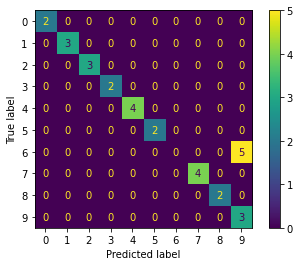

In [13]:
y_pred = clf.predict(x_val)
evaluated_metrics(y_val, y_pred)

### Test process

Accuracy =  96.66666666666667 %
Precision =  97.77777777777777 %


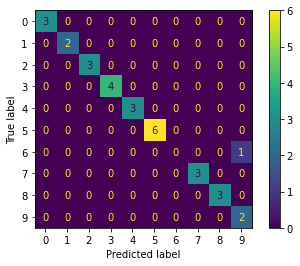

In [14]:
y_pred = clf.predict(x_test)
evaluated_metrics(y_test, y_pred)